C:\Users\orenc\AppData\Local\Temp\ipykernel_7976\508518353.py:54: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  GG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
c:\mArt\dataScience\Practice_3sem\project's\1\.venv\lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 103 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


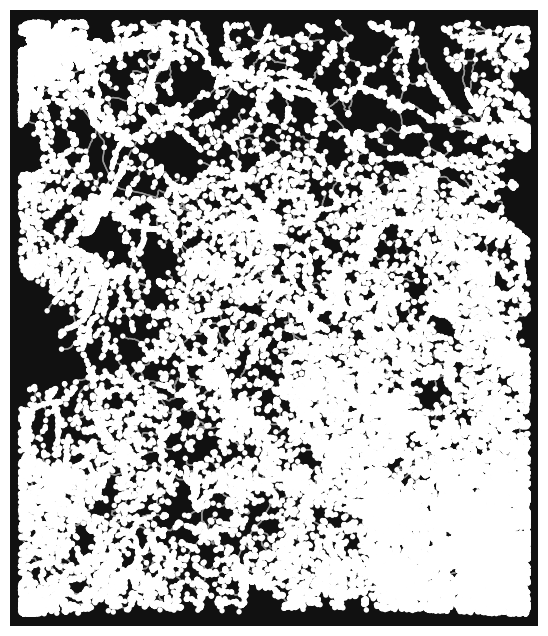

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx

def func(x):
    return x[0]

def func_1(x):
    gdf_1 = ox.geocode_to_gdf(x, by_osmid=True)
    return gdf_1[['lat', 'lon']]

def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(func) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(func_1).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

tags_port = {'industrial' : 'port'} # port cargo
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

city_from = 'Saint Petersburg'
city_to = 'Moscow'

full_df_from = pd.concat([func_tags(tags_port, city_from), func_tags(tags_aeroway, city_from), func_tags(tags_landuse, city_from), func_tags(tags_build, city_from)], ignore_index=True)
full_df_to = pd.concat([func_tags(tags_port, city_to), func_tags(tags_aeroway, city_to), func_tags(tags_landuse, city_to), func_tags(tags_build, city_to)], ignore_index=True)

G_from = ox.graph_from_place(city_from, retain_all=True, simplify = True, network_type='drive')
G_to = ox.graph_from_place(city_to, retain_all=True, simplify = True, network_type='drive')

lat_from = list(full_df_from['lat'].values)
lon_from = list(full_df_from['lon'].values)

lat_to = list(full_df_to['lat'].values)
lon_to = list(full_df_to['lon'].values)

full_graph = nx.compose_all([G_from, G_to])
full_df_from['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_from, lat_from)
full_df_to['new_nodes'] = ox.distance.nearest_nodes(full_graph, lon_to, lat_to)

gdf_nodes, gdf_relationships = ox.graph_to_gdfs(full_graph)
north, south, east, west = gdf_nodes[['y']].max(), gdf_nodes[['y']].min(), gdf_nodes[['x']].min(), gdf_nodes[['x']].max()
GG = ox.graph_from_bbox(bbox = (north, south, east, west), network_type='drive')
ox.plot_graph(GG)

In [8]:
full_df_from.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
0,Морской рыбный порт,59.868541,30.211642,"POLYGON ((30.20579 59.87000, 30.20715 59.86948...","[700371906, 7194252008, 7194252007, 700371673,...",industrial,700371846
2,Нева-Металл,59.884243,30.203732,"POLYGON ((30.21001 59.88024, 30.21024 59.88037...","[1495854361, 1495854367, 1495854405, 149585443...",industrial,2930268667


In [9]:
full_df_to.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
75,Полигон упаковки ТБО,55.728720,37.697890,"POLYGON ((37.69748 55.72839, 37.69841 55.72845...","[6883658353, 6883658354, 6883658355, 688365835...",building,304928562
70,Кузовной ремонт,55.844603,37.557993,"POLYGON ((37.55791 55.84473, 37.55819 55.84452...","[2119077358, 2119077339, 2119077326, 211907734...",building,4402724045


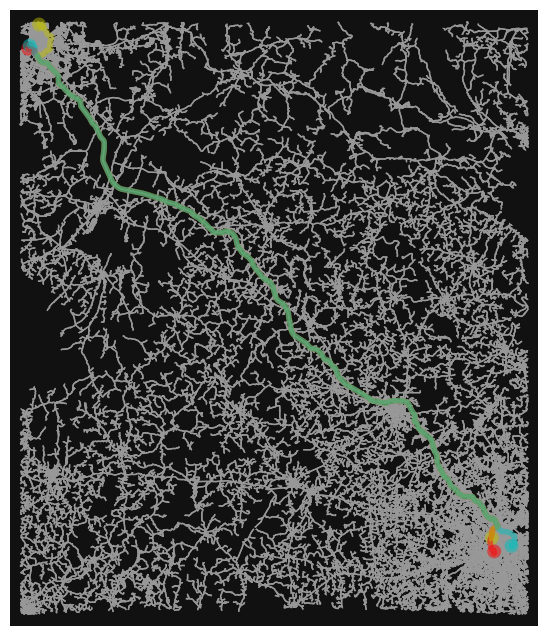

In [10]:
route1 = nx.shortest_path(GG, 1837026892, 4075173808)
route2 = nx.shortest_path(GG, 243760498, 303902679)
route3 = nx.shortest_path(GG, 2930268667, 304928562)
routes = [route1, route2, route3]
rc = ['r', 'y', 'c']
fig, ax = ox.plot_graph_routes(GG, routes, route_colors=rc, route_linewidth=6, node_size=0)

In [14]:
basic_stats = ox.basic_stats(GG)
print(basic_stats['circuity_avg'])

1.0868360769208099


In [16]:
ox.routing.route_to_gdf(GG, route1, weight='length').head()

,,,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,geometry,ref,bridge,width,tunnel
u,v,key,,,,,,,,,,,,,
1837026892,2271324973,0,"[217829209, 172852138, 172852141]",False,2,улица Доблести,unclassified,RU:urban,True,455.599,"LINESTRING (30.18665 59.86912, 30.18539 59.867...",NaN,NaN,NaN,NaN
2271324973,1981182833,0,985569478,True,2,улица Доблести,secondary,RU:urban,False,27.410,"LINESTRING (30.18328 59.86544, 30.18301 59.86524)",NaN,NaN,NaN,NaN
1981182833,698846376,0,137598572,True,3,улица Маршала Казакова,secondary,RU:urban,False,9.364,"LINESTRING (30.18301 59.86524, 30.18316 59.86521)",NaN,NaN,NaN,NaN
698846376,943980784,0,"[993449828, 425410061]",True,"[3, 2]",улица Маршала Казакова,secondary,RU:urban,False,188.131,"LINESTRING (30.18316 59.86521, 30.18342 59.865...",NaN,NaN,NaN,NaN
943980784,943980795,0,425410061,True,2,улица Маршала Казакова,secondary,RU:urban,False,199.084,"LINESTRING (30.18626 59.86454, 30.18950 59.86379)",NaN,NaN,NaN,NaN


___

**ПРИМЕР**

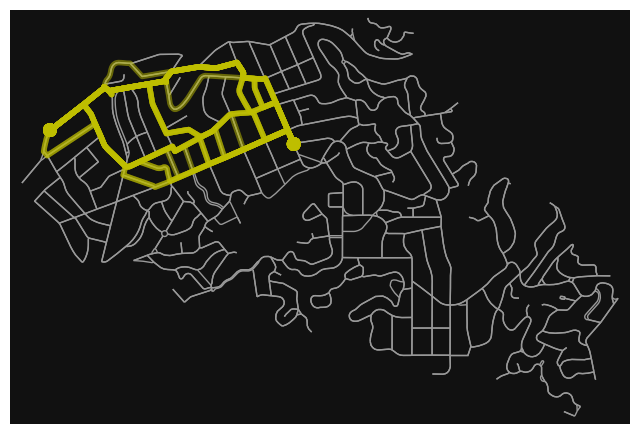

In [1]:
import osmnx as ox

place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")

# find the shortest path (by distance)
# between these nodes then plot it
orig = list(G)[0]
dest = list(G)[140]

# find k-shortest path
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(
    G, list(routes), route_colors="y",
    route_linewidth=4, node_size=0)

In [2]:
import osmnx as ox


def generate_multindex(route_nodes):
    multiindex_list = []
    # append the index to list
    for u, v in zip(route_nodes[:-1], route_nodes[1:]):
        multiindex_list.append((u, v, 0))
    return multiindex_list


# load the map data
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")

# find the shortest path (by distance)
# between these nodes then plot it
orig = list(G)[0]
dest = list(G)[140]

# fetch k shortest path
routes_nodes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")

# get edges from from above multidigraph
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# generate multiindex based on generated shortest route
routes_index_list = []
for route_nodes in routes_nodes:
    multiindex_list = generate_multindex(route_nodes)
    routes_index_list.extend(multiindex_list)

# fetch edge details based on multi index list
shrt_gdf_edges = gdf_edges[gdf_edges.index.isin(routes_index_list)]
# plot the shortest route on map
shrt_gdf_edges.explore(color="red")

___

**ЕЩЕ ОДНА ПОПЫТКА**

In [5]:
full_df_from.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
33,Дом 12,59.930358,30.291811,"POLYGON ((30.29099 59.93090, 30.29158 59.93109...","[[[1132309002, 1132309058, 1132309018, 1382340...",building,1603477035
23,Heléns,60.069948,30.349532,"POLYGON ((30.34939 60.07021, 30.34907 60.06981...","[3233059109, 3233060625, 1502246236, 150224623...",building,243760498


In [7]:
full_df_to.sample(2)

,name,lat,lon,geometry,nodes,kind_of,new_nodes
37,Москва-Рижская,55.79692,37.629122,"POLYGON ((37.60854 55.80016, 37.60854 55.80024...","[[[493080435, 658997504], [658997504, 65899750...",landuse,303790896
58,"Торговый центр ""К-24""",55.72852,37.579992,"POLYGON ((37.58049 55.72898, 37.57977 55.72871...","[578922679, 7851378376, 578922585, 7851378382,...",building,988236108


In [14]:
full_df_from[full_df_from['new_nodes'] == 22283853]

,name,lat,lon,geometry,nodes,kind_of,new_nodes
21,Склад РТИ,59.887362,30.332532,"POLYGON ((30.33217 59.88751, 30.33258 59.88752...","[1215797732, 1215797723, 1215797720, 121579773...",building,22283853


In [4]:
route = nx.shortest_path(GG, 22283853, 1577926006)
shortest_route_map = ox.plot_route_folium(GG, route)
shortest_route_map

C:\Users\orenc\AppData\Local\Temp\ipykernel_7976\556297818.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  shortest_route_map = ox.plot_route_folium(GG, route)


In [9]:
shortest_route_map = ox.plot_route_folium(GG, route, 
                                          tiles='openstreetmap')
shortest_route_map

C:\Users\orenc\AppData\Local\Temp\ipykernel_7976\1735028666.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  shortest_route_map = ox.plot_route_folium(GG, route,


In [16]:
import folium

start_latlng = (59.887362, 30.332532)
end_latlng   = (55.58783, 37.608322)
start_location = "Склад РТИ, СПб"
end_location = "Складовка, Москва"

start_marker = folium.Marker(
            location = start_latlng,
            popup = start_location,
            icon = folium.Icon(color='green'))

end_marker = folium.Marker(
            location = end_latlng,
            popup = end_location,
            icon = folium.Icon(color='red'))

start_marker.add_to(shortest_route_map)
end_marker.add_to(shortest_route_map)
shortest_route_map